# <center> <b>YAMNet prototype defender of terroristics atacks <center> </b>

In [ ]:
## <center> <b> process data <center> </b>

In [39]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [40]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [41]:
import tensorflow as tf
import tensorflow_io as tfio

@tf.function
def load_audio_16k_mono(filename):
    try:
        audio = tfio.audio.decode_mp3(tf.io.read_file(filename))

        sample_rate = tf.cast(44100, dtype=tf.int64) # Default MP3 sample rate. Might not always be true!

        audio = tfio.audio.resample(audio, rate_in=sample_rate, rate_out=16000)
        # Ensure the audio is float32 and normalized to [-1, 1]
        # audio = tf.cast(audio, tf.float32) / 32768.0

        audio = tf.reduce_mean(audio, axis=1, keepdims=True)
        audio = tf.reshape(audio, [-1]) 
    except:
        audio = None
    return audio

In [42]:
testing_wav_data = []

testing_wav_data.append(load_audio_16k_mono(r'Sounds\samples\IMG_9658.mp3'))
testing_wav_data.append(load_audio_16k_mono(r'Sounds\samples\2024-11-19 18-28-18.mp3'))
testing_wav_data.append(load_audio_16k_mono(r'Sounds\samples\Chiikawa Usagi.mp3'))

testing_wav_key = ['Выстрел', 'Другое(бит)', 'Другое(музыка)']

In [43]:
import pandas as pd

import os

data = {'filename' : map(lambda x: 'nuke/'+x,list(filter(lambda x: x.startswith('converted_'), os.listdir('Sounds/nuke/')))[:100]),
        'category' : 'Выстрелы',
        }

data1 = {'filename' : map(lambda x: 'other/'+x,list(filter(lambda x: x.startswith('converted_'), os.listdir('Sounds/other/')))[:100]),
        'category' : 'Другие',
        }

data2 = {'filename' : map(lambda x: 'fireworks/'+x,list(filter(lambda x: x.startswith('converted_'), os.listdir('Sounds/fireworks/')))[:100]),
        'category' : 'Фейерверки',
        }

data3 = {'filename' : map(lambda x: 'concatenate/'+x,list(filter(lambda x: x.startswith('converted_'), os.listdir('Sounds/concatenate/')))[:100]),
        'category' : 'Выстрелы',
        }

base_data_path = './Sounds'

def create_folds(df, proportions, random_state):

    if not np.isclose(sum(proportions.values()), 1):
        raise ValueError("Сумма долей должна быть равна 1.")

    np.random.seed(random_state)

    n_rows = len(df)
    folds = []
    start_index = 0
    for value, proportion in proportions.items():
        n_elements = int(round(n_rows * proportion))
        folds.extend([value] * n_elements)
        start_index += n_elements

    if len(folds) < n_rows:
        diff = n_rows - len(folds)
        folds.extend([value]*diff)
    
    np.random.shuffle(folds)

    df['folds'] = folds
    return df

df = pd.DataFrame(data)
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)


proportions = {1: 0.70, 2: 0.20, 3: 0.10}
df = create_folds(df, proportions, random_state=42)
df1 = create_folds(df1, proportions, random_state=42)
df2 = create_folds(df2, proportions, random_state=42)
df3 = create_folds(df3, proportions, random_state=42)

pd_data = pd.concat([df, df1, df2, df3])

In [44]:
my_classes = ['Выстрелы', 'Другие', 'Фейерверки']
map_class_to_id = {'Выстрелы':0, 'Другие':1, 'Фейерверки':2}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,category,folds,target
0,./Sounds\nuke/converted_nuke_0.mp3,Выстрелы,2,0
1,./Sounds\nuke/converted_nuke_1.mp3,Выстрелы,1,0
2,./Sounds\nuke/converted_nuke_10.mp3,Выстрелы,2,0
3,./Sounds\nuke/converted_nuke_100.mp3,Выстрелы,1,0
4,./Sounds\nuke/converted_nuke_101.mp3,Выстрелы,1,0
5,./Sounds\nuke/converted_nuke_102.mp3,Выстрелы,1,0
6,./Sounds\nuke/converted_nuke_103.mp3,Выстрелы,1,0
7,./Sounds\nuke/converted_nuke_104.mp3,Выстрелы,2,0
8,./Sounds\nuke/converted_nuke_105.mp3,Выстрелы,1,0
9,./Sounds\nuke/converted_nuke_106.mp3,Выстрелы,1,0


In [45]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['folds']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [46]:
def load_wav_for_map(filename, label, fold):
    return load_audio_16k_mono(filename), label, fold 

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [47]:

def extract_embedding(wav_data, label, fold):
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [48]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold == 1)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 2)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 3)

remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(20).batch(16).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(16).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(16).prefetch(tf.data.AUTOTUNE)

## <center> <b> model <center> </b>

#### model

In [49]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input
# from tensorflow.keras.mixed_precision import Policy, set_global_policy

# policy = Policy('mixed_float16')
# set_global_policy(policy)

FineTuned = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
])


FineTuned.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 526,339
Trainable params: 526,339
Non-trainable params: 0
_________________________________________________________________


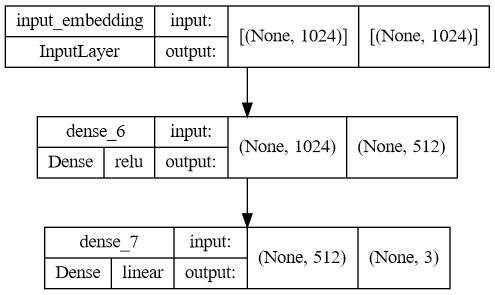

In [50]:
from keras.utils.vis_utils import plot_model
plot_model(FineTuned, r'C:\My_projects\nuke\metrics\architecture\YAMNet_finetuned.png', show_shapes=True, show_layer_activations = True)

In [51]:
FineTuned.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer="adam",
                    metrics=['accuracy'])

In [52]:
hist = FineTuned.fit(train_ds,
                        epochs=150,
                        validation_data=val_ds,
                        # callbacks=callback
                        )

Epoch 1/150
701/701 [==============================] - 202s 285ms/step - loss: 0.8377 - accuracy: 0.9550 - val_loss: 9.6381 - val_accuracy: 0.1106
Epoch 2/150
701/701 [==============================] - 4s 5ms/step - loss: 0.6157 - accuracy: 0.9507 - val_loss: 12.4864 - val_accuracy: 0.1106
Epoch 3/150
701/701 [==============================] - 4s 5ms/step - loss: 0.4632 - accuracy: 0.9519 - val_loss: 11.1928 - val_accuracy: 0.1106
Epoch 4/150
701/701 [==============================] - 4s 5ms/step - loss: 0.4653 - accuracy: 0.9422 - val_loss: 14.3797 - val_accuracy: 0.1106
Epoch 5/150
701/701 [==============================] - 4s 5ms/step - loss: 0.6852 - accuracy: 0.9318 - val_loss: 13.8623 - val_accuracy: 0.1106
Epoch 6/150
701/701 [==============================] - 4s 5ms/step - loss: 0.6423 - accuracy: 0.9330 - val_loss: 17.3519 - val_accuracy: 0.1106
Epoch 7/150
701/701 [==============================] - 4s 5ms/step - loss: 0.7891 - accuracy: 0.9324 - val_loss: 14.6957 - val_accura

In [53]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

In [54]:
saved_model_path = './models/yamnet_funetened'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = FineTuned(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./models/yamnet_funetened\assets


INFO:tensorflow:Assets written to: ./models/yamnet_funetened\assets


#### test

In [55]:
for i in range(len(testing_wav_data)):
    scores, embeddings, spectrogram = yamnet_model(testing_wav_data[i])
    result = FineTuned(embeddings).numpy()

    inferred_class = my_classes[result.mean(axis=0).argmax()]
    print(f'Предсказанный класс: {inferred_class}, реальный класс {testing_wav_key[i]}')

Предсказанный класс: Выстрелы, реальный класс Выстрел
Предсказанный класс: Выстрелы, реальный класс Другое(бит)
Предсказанный класс: Другие, реальный класс Другое(музыка)


#### visualize

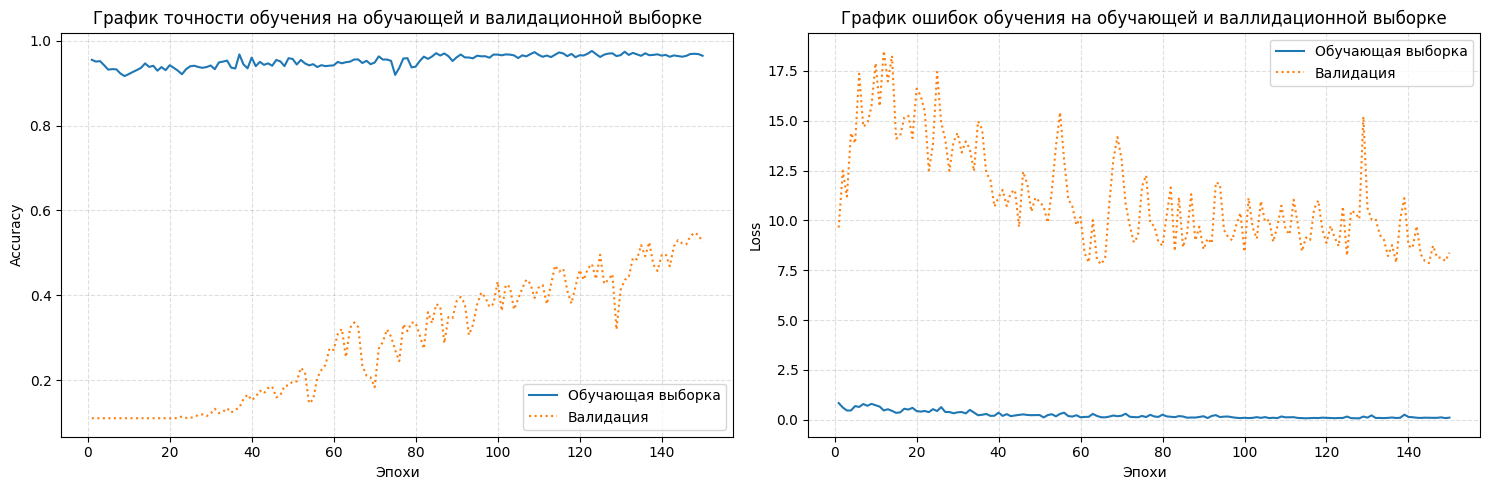

In [56]:
acc_plot = hist.history['accuracy']
ls_plot = hist.history['loss']

val_acc_plot = hist.history['val_accuracy']

val_ls_plot = hist.history['val_loss']
epochs = list(range(1, len(acc_plot) + 1))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_plot, '-', label='Обучающая выборка')
plt.plot(epochs, val_acc_plot, ':', label='Валидация')
plt.title('График точности обучения на обучающей и валидационной выборке')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, color='gray', alpha = 0.25, linestyle='--')
plt.tight_layout()

# plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs, ls_plot, '-', label='Обучающая выборка')
plt.plot(epochs, val_ls_plot, ':', label='Валидация')
plt.title('График ошибок обучения на обучающей и валлидационной выборке')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, color='gray', alpha = 0.25, linestyle='--')
plt.tight_layout()
plt.savefig(r'C:\My_projects\nuke\metrics\matplot\YAMNet_metrics_accuracy_and_loss.png')
plt.show()

In [57]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py

acc_plot = hist.history['accuracy']
ls_plot = hist.history['loss']

val_acc_plot = hist.history['val_accuracy']

val_ls_plot = hist.history['val_loss']
epochs = list(range(1, len(acc_plot) + 1))

fig = make_subplots(rows=1, cols=2, subplot_titles=("<b>Accuracy</b>", "<b>Loss</b>",), horizontal_spacing=0.05)

# Accuracy
fig.add_trace(go.Scatter(x=list(epochs), y=acc_plot, legendgroup='<b>Training</b>', name='<b>Training</b>',
                            line=dict(shape='spline', smoothing=0.8, color='#636efb'), mode='markers+lines', marker=dict(color='#636efb')), row=1, col=1)
fig.add_trace(go.Scatter(x=list(epochs), y=val_acc_plot, legendgroup='<b>Validation</b>', name='<b>Validation</b>',
                            line=dict(shape='spline', smoothing=0.8, dash='dot', color='red'), mode='markers+lines', marker=dict(color='red')), row=1, col=1)

# Loss
fig.add_trace(go.Scatter(x=list(epochs), y=ls_plot, legendgroup='<b>Training</b>', name='<b>Training</b>', showlegend=False,
                            line=dict(shape='spline', smoothing=0.8, color='#636efb'), mode='markers+lines', marker=dict(color='#636efb')), row=1, col=2)
fig.add_trace(go.Scatter(x=list(epochs), y=val_ls_plot, legendgroup='<b>Validation</b>', name='<b>Validation</b>', showlegend=False,
                            line=dict(shape='spline', smoothing=0.8, dash='dot', color='red'), mode='markers+lines', marker=dict(color='red')), row=1, col=2)


fig.update_traces(hovertemplate='Epoch: %{x}<br>Value: %{y}')

fig.update_yaxes(title_text="<b>Показатели</b>")
fig.update_xaxes(title_text="<b>Эпохи</b>")
fig.update_layout(legend=dict(font=dict(size=14), bgcolor='lightgray'))


fig.update_layout(
    height=550, 
    width=2000, 
    title_text="<b>Метрики обучения</b>",
    legend=dict(
        font=dict(size=14),
        bgcolor='rgba(240, 240, 240, 0.5)',
        bordercolor='rgba(200, 200, 200, 1)',
        borderwidth=1,
    ),
    plot_bgcolor='rgba(210, 210, 210, 0.5)',
    
    # paper_bgcolor='rgba(250, 250, 250, 1)'
)
fig.update_xaxes(range=[0.5, max(epochs)+0.3])
py.plot(fig, filename=r'C:\My_projects\nuke\metrics\plotly\YAMNet_metrics_accuracy_and_loss.html')
fig.write_image(r"C:\My_projects\nuke\metrics\plotly\YAMNet_metrics_accuracy_and_loss.svg")
fig.show()

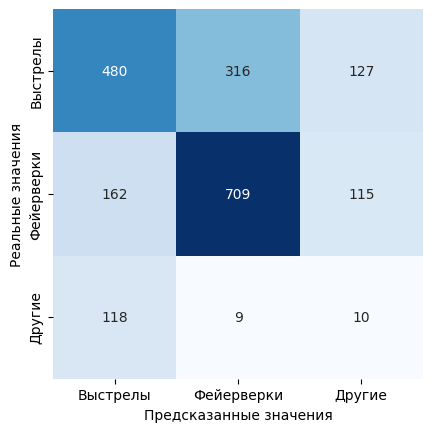

In [58]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = []
for _, y in test_ds:
    y_true.extend(y.numpy())

y_predicted = FineTuned.predict(test_ds)

class_labels = ['Выстрелы', 'Фейерверки', 'Другие']
mat = confusion_matrix(np.array(y_true), np.argmax(y_predicted, axis=1))
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Предсказанные значения')
plt.ylabel('Реальные значения')
plt.savefig(r'C:\My_projects\nuke\metrics\confusion_matrix_YAMNet.png')